In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import warnings # This is a library that handles warnings.

In [26]:
# Path to your csv file
csv_file_path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/cooling_boiler_trimmed_3.csv'

# Import 
cooling_boiler_df = pd.read_csv(csv_file_path)  

# Verify the import
print(cooling_boiler_df.dtypes.to_string())

utility_id                                              int64
state                                                  object
plant_code                                              int64
plant_name                                             object
year                                                    int64
month                                                   int64
generator_id                                           object
boiler_id                                              object
cooling_id                                             object
generator_primary_technology                           object
fuel_consumption_from_all_fuel_types_mmbtu            float64
water_withdrawal_volume_million_gallons               float64
water_consumption_volume_million_gallons              float64
cooling_unit_hours_in_service                         float64
avg_distance_water_intake                             float64
cooling_type_1_860                                     object
cooling_

## ✅ 1. Parse and Prepare the Date

In [30]:
cooling_boiler_df['date'] = pd.to_datetime(cooling_boiler_df['date'])


## ✅ 2. Subset the Data 

In [34]:
subset_df = (
    cooling_boiler_df[['date', 'water_withdrawal_volume_million_gallons']]
    .dropna()  # Drop rows with missing water withdrawal
)


## 📝 Subset Explanation 
#### (AZ + ChatGPT)

For this time series analysis, we created a simplified subset of the data by selecting only the two relevant variables: `date` and `water_withdrawal_volume_million_gallons`. The latter is our continuous variable of interest. We also dropped any rows containing missing (`NaN`) values to ensure a clean analysis.

While our broader project focuses on using patterns of missingness to guide predictive modeling and oversight (e.g. via Edge AI systems), we begin here with a more focused analysis of actual reported withdrawal volumes. This allows us to explore underlying trends and seasonality, and prepare for future forecasting exercises.

In later phases of the project, we plan to revisit missingness directly—potentially using the `water_metrics_missing` variable, or subsetting based on known anomalies identified during prior clustering (e.g. suspicious reporting patterns in clusters 3 and 4 from our agglomerative clustering analysis). We may also explore time series behaviors across specific cooling configurations or fuel types.

---

In [36]:
# Convert and set as index
subset_df['date'] = pd.to_datetime(subset_df['date'])
subset_df.set_index('date', inplace=True)


## ✅ 3. Group to Monthly Aggregates

In [39]:
monthly_df = (
    subset_df
    .resample('M')  # monthly frequency
    .sum()
)


#### ✔ We didn’t reset the index because we didn’t subset by time range.
#### ✔ We used .resample() immediately after setting the index (perfect for monthly aggregation.)

## ✅ 4. Plot the Line Chart

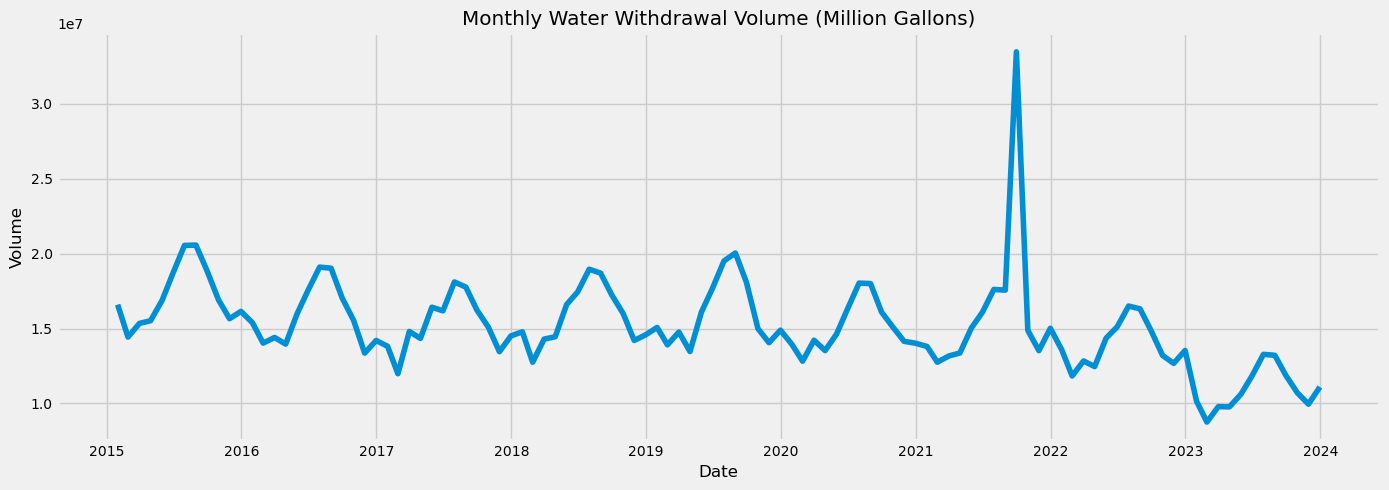

In [42]:
## import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 5))
plt.plot(monthly_df.index, monthly_df['water_withdrawal_volume_million_gallons'])
plt.title("Monthly Water Withdrawal Volume (Million Gallons)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()


# ⏰ TIME SERIES DECOMPOSITION

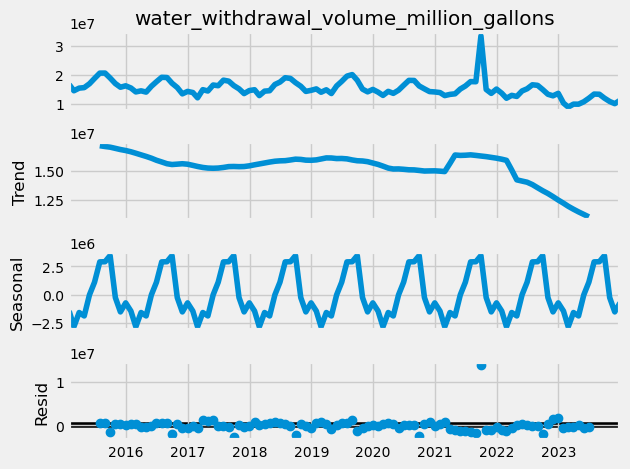

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    monthly_df['water_withdrawal_volume_million_gallons'],
    model='additive',  # or 'multiplicative' if there's % growth
    period=12  # monthly data, so 12-month cycle
)

fig1 = decomposition.plot()
plt.tight_layout()
plt.show()


### 📉 Time Series Decomposition Analysis
#### (AZ+ChatGPT)
The decomposition plot reveals several important features about the water withdrawal data.

* **Trend Component:**
  The second line shows the underlying trend, which differs noticeably from the raw level. This confirms the need for smoothing, as the original signal was dominated by short-term fluctuations. Beneath what initially appeared to be a relatively flat, autocorrelated series before 2021, the trend reveals a subtle decline followed by a gradual climb—details that were obscured in the raw signal.

  The 2021 spike still stands out, but the trendline tempers its extremity, allowing us to see it more in context. Post-2021, the downward trajectory in water withdrawal becomes much clearer, possibly reflecting systemic changes.

* **Seasonality:**
  The third line confirms the presence of strong seasonal patterns, with consistent spikes and dips repeating over the years. This suggests that thermoelectric water use is influenced by regular seasonal cycles—potentially due to energy demand fluctuations (e.g. summer cooling or winter heating loads).

* **Residual/Noise Component:**
  The final graph shows the residuals (what’s left after removing trend and seasonality). There's significant noise during the late 2021 to early 2022 period, confirming this was a statistically unusual time—an outlier in the data.

  This could reflect real-world factors, such as a surge in industrial activity post-COVID, or increased water intensity from data centers or extreme climate events. Encouragingly, the declining water use trend since 2022 may point to improved efficiency in thermoelectric cooling or energy generation systems.

---

# 🧪 Dickey-Fuller Test

In [59]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_df['water_withdrawal_volume_million_gallons'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


ADF Statistic: 0.46260438337459603
p-value: 0.9836910567573041
Critical Values: {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}


### 👀 Observation: 
98% chance that one would encounter a time-series this non-stationary just by random chance if there were a unit root (null hypothesis true).

#### Next step: first-order differencing (ie subtracting each month's value from the one before it)

In [63]:
diff_1 = monthly_df['water_withdrawal_volume_million_gallons'].diff().dropna()

# Re-run ADF test on differenced data
result_diff_1 = adfuller(diff_1)
print('ADF Statistic:', result_diff_1[0])
print('p-value:', result_diff_1[1])
print('Critical Values:', result_diff_1[4])


ADF Statistic: -7.190800189393431
p-value: 2.506728093079242e-10
Critical Values: {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}


### Results: 
- ADF Statistic: −7.19 → Very negative
- p-value: 2.5e-10 → Essentially zero

Null hypothesis can now be rejected.

## Plot differenced data.

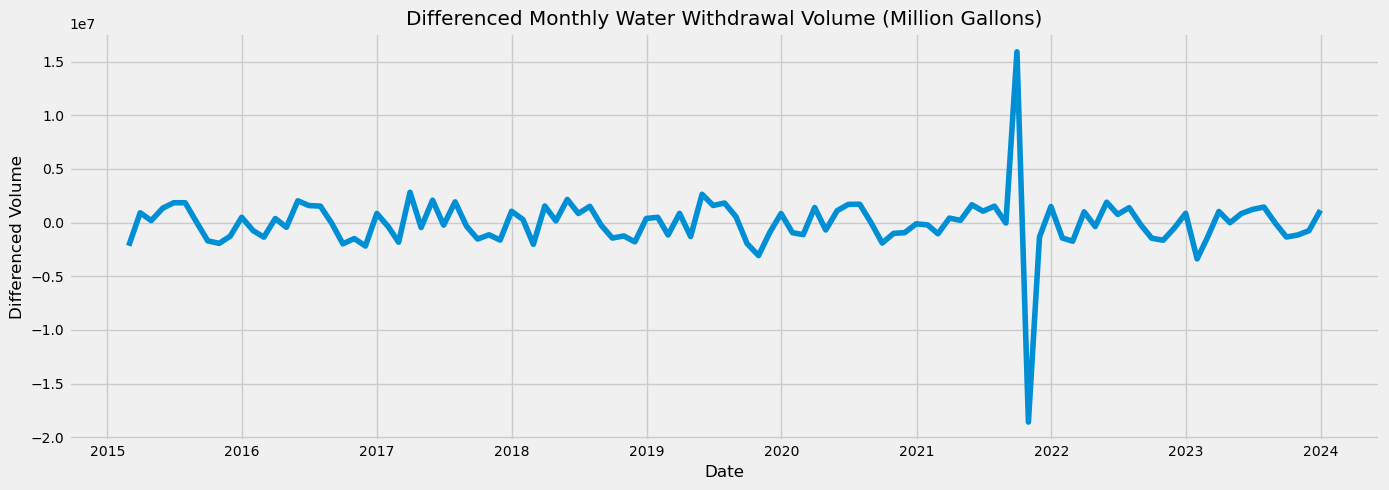

<Figure size 1400x500 with 0 Axes>

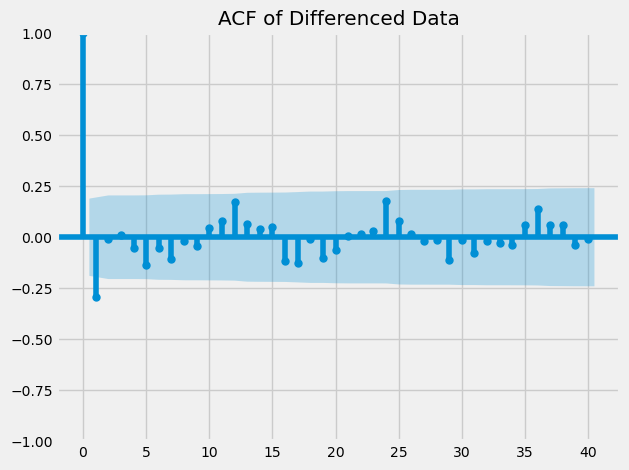

<Figure size 1400x500 with 0 Axes>

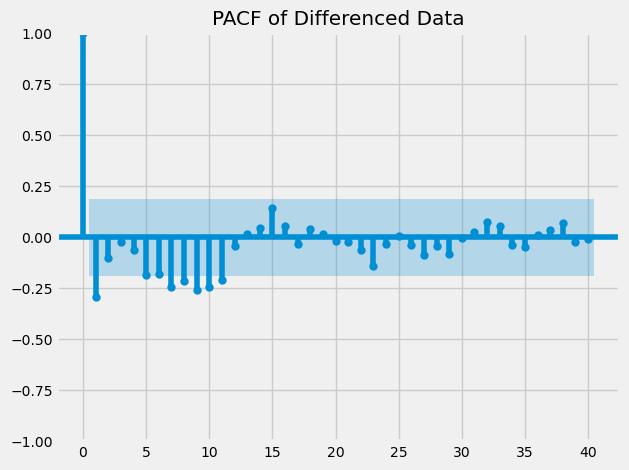

In [67]:
# First order differencing of the data (if you haven't already)
differenced_df = monthly_df['water_withdrawal_volume_million_gallons'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(14, 5))
plt.plot(differenced_df)
plt.title('Differenced Monthly Water Withdrawal Volume (Million Gallons)')
plt.xlabel('Date')
plt.ylabel('Differenced Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

# Now, ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(14, 5))
plot_acf(differenced_df, lags=40)  # You can adjust the number of lags
plt.title('ACF of Differenced Data')
plt.tight_layout()
plt.show()

# PACF plot
plt.figure(figsize=(14, 5))
plot_pacf(differenced_df, lags=40)  # You can adjust the number of lags
plt.title('PACF of Differenced Data')
plt.tight_layout()
plt.show()


## 🔎 ACF and PACF Observations 

### ACF (Autocorrelation Function):

In the ACF plot, there are no significant spikes outside the blue confidence interval, except at lag 0, where the series correlates perfectly with itself. Additionally, lag 1 shows a value slightly outside the confidence interval. Overall, this suggests that the data does not exhibit long-term dependencies, as there are no other significant autocorrelations beyond lag 1.

### PACF (Partial Autocorrelation Function):

In the PACF plot, we see that lag 1, as well as lags 5 through 11, fall outside the blue confidence interval. This indicates that there are dependencies at these specific lags. The presence of these significant partial autocorrelations suggests that certain lags are important in modeling the series and should be considered when determining the appropriate parameters for an AR model.

---